# The data
The dataset is open sourced data from Kaggle. \
data sample: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?resource=download&select=flights_sample_3m.csv \
full data: https://www.kaggle.com/code/alperenkaran/visualization-of-flight-delays/input

In [50]:
import sys
sys.path.append('../src')

In [51]:
import pandas as pd
from pathlib import Path

import seaborn as sns

from airline_delay.visualization.dataframe_explore import report_columns_inspection
from airline_delay.data.make_datasets import make_airline_dataframe

In [52]:
df_flt = make_airline_dataframe(
    Path('../data/flights_sample_3m.csv')
)

In [53]:
# check missing values
miss_ser = df_flt.isna().sum()

miss_val = pd.DataFrame({
    'Missing Values':miss_ser.values,
    'Missing %age':round((miss_ser/df_flt.shape[0])*100,4).astype(str) + '%',
    'Datatype':df_flt.dtypes
})

miss_val.sort_values(by='Missing %age', ascending=False)

,Missing Values,Missing %age,Datatype
CANCELLATION_CODE,2920860,97.362%,object
DELAY_DUE_LATE_AIRCRAFT,2466137,82.2046%,float64
DELAY_DUE_SECURITY,2466137,82.2046%,float64
DELAY_DUE_NAS,2466137,82.2046%,float64
DELAY_DUE_WEATHER,2466137,82.2046%,float64
DELAY_DUE_CARRIER,2466137,82.2046%,float64
AIR_TIME,86198,2.8733%,float64
ELAPSED_TIME,86198,2.8733%,float64
ARR_DELAY,86198,2.8733%,float64
WHEELS_ON,79944,2.6648%,float64


We now preprocess the data and see the changes in the summary statistics.

In [54]:
def preprocess(df):
    orig_count = df.shape[0]
    # remove cancelled flights and diverted flights
    df = df.loc[(df["CANCELLED"]==0)&(df["DIVERTED"]==0)]
    # remove records with important feature missing
    df = df.dropna(subset = ["AIR_TIME","ARR_TIME","DEP_TIME"])
    print(f"{(100*(orig_count - df.shape[0])/orig_count):.2f} % of data are removed.")
    
    # convert fl_date to date 
    if df["FL_DATE"].dtype == "object":
        df["FL_DATE"] = pd.to_datetime(df["FL_DATE"], format = "%Y-%m-%d")
    
    return df

In [55]:
df_flt_clean = preprocess(df_flt)

2.87 % of data are removed.


In [56]:
# check missing values
miss_ser = df_flt_clean.isna().sum()

miss_val = pd.DataFrame({
    'Missing Values':miss_ser.values,
    'Missing %age':round((miss_ser/df_flt_clean.shape[0])*100,4).astype(str) + '%',
    'Datatype':df_flt_clean.dtypes
})

miss_val.sort_values(by='Missing %age', ascending=False)

,Missing Values,Missing %age,Datatype
DELAY_DUE_LATE_AIRCRAFT,2379939,81.6781%,float64
DELAY_DUE_SECURITY,2379939,81.6781%,float64
DELAY_DUE_NAS,2379939,81.6781%,float64
DELAY_DUE_WEATHER,2379939,81.6781%,float64
DELAY_DUE_CARRIER,2379939,81.6781%,float64
CANCELLATION_CODE,2913802,100.0%,object
AIRLINE,0,0.0%,object
DISTANCE,0,0.0%,float64
AIR_TIME,0,0.0%,float64
ELAPSED_TIME,0,0.0%,float64


When we drop the cancelled flights the remaining flights have a missing cancellation code. So this column should be eventually dropped.

Flights that are not delayed will have missing values for delay columns. These should not be filled with mean or median. They should be filled with 0.

In [57]:
# check duplicates
len(df_flt) == len(df_flt.drop_duplicates())

True

## Add Additional features (month, day of week, departure hour)

In [58]:
def add_additional_features(df):
    df["flt_month"] = df["FL_DATE"].dt.month
    df["flt_day_of_week"] = df["FL_DATE"].dt.dayofweek
    df["schd_dep_hour"] = df["CRS_DEP_TIME"].astype("str").str[:-2]
    df.loc[df["schd_dep_hour"]=="", "schd_dep_hour"] = "0"
    return df

In [59]:
df_flt_clean = add_additional_features(df_flt_clean)

## Check distribution of features

In [60]:
df_flt_clean.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT', 'flt_month', 'flt_day_of_week',
       'schd_dep_hour'],
      dtype='object')

In [61]:
# look at airlines included in the dataset
report_columns_inspection(df_flt_clean, columns=['AIRLINE_CODE'])

+--------------+---------------+-------------+--------------+--------------+
|    Column    | options_count | options_set | values_count | values_ratio |
+--------------+---------------+-------------+--------------+--------------+
| AIRLINE_CODE |       18      |      UA     |    248270    |     0.09     |
|      -       |       -       |      DL     |    388475    |     0.13     |
|      -       |       -       |      NK     |    93200     |     0.03     |
|      -       |       -       |      WN     |    555869    |     0.19     |
|      -       |       -       |      AA     |    371218    |     0.13     |
|      -       |       -       |      YX     |    138147    |     0.05     |
|      -       |       -       |      AS     |    98294     |     0.03     |
|      -       |       -       |      B6     |    109447    |     0.04     |
|      -       |       -       |      OH     |    103483    |     0.04     |
|      -       |       -       |      G4     |    50179     |     0.02     |

<Axes: >

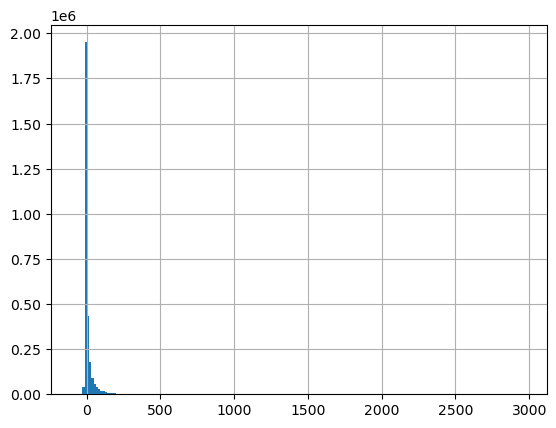

In [62]:
# check distribution of DEP_DELAY
df_flt_clean['DEP_DELAY'].hist(bins=200)

<Axes: xlabel='AIRLINE'>

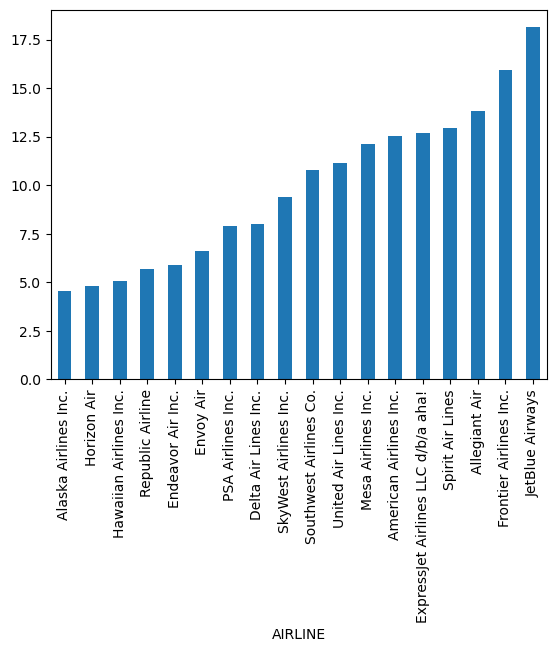

In [63]:
# look at average of DEP_DELAY for each airline
df_flt_clean.groupby('AIRLINE')['DEP_DELAY'].mean().sort_values().plot(kind='bar')

<Axes: xlabel='flt_month'>

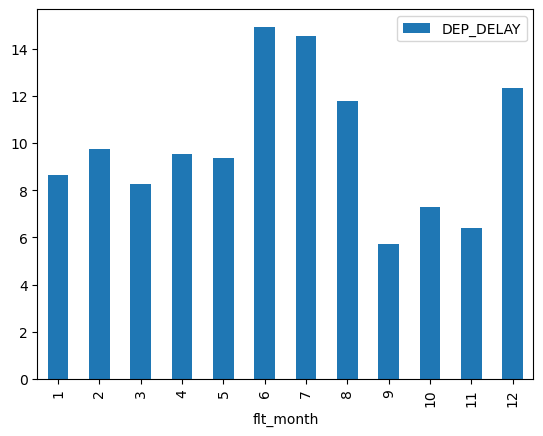

In [68]:
#get delay per month
df_flt_clean.groupby('flt_month')['DEP_DELAY'].mean().reset_index().sort_values('flt_month').plot(x='flt_month', kind='bar')

<Axes: >

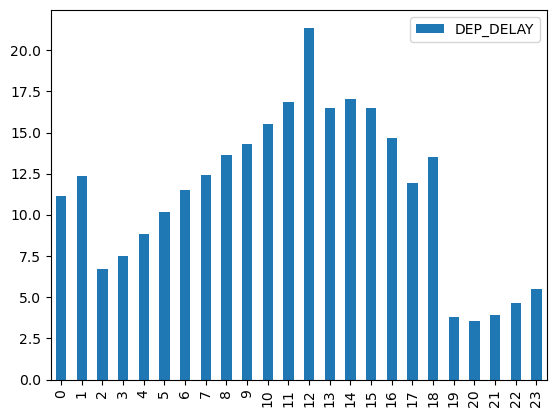

In [69]:
# get delay per hour of departure
df_flt_clean.groupby('schd_dep_hour')['DEP_DELAY'].mean().reset_index().sort_values('schd_dep_hour').plot(kind='bar')